#In this exam, I will test if you understand what is going on in this notebook for text classification. 
# Because it explains this notebook very well, I refer to the following paper, espeially the diagrams#Cf: https://humboldt-wi.github.io/blog/research/information_systems_1819/group4_ulmfit/#forwardpass 

I WILL ask you to explain the diagrams and sometimes ask which parts of this notebook corresponds to parts of each diagram.

To prepare the exam, you should execute every cell and try to guess what the command used mean by looking at the displayed result.

Also we need to download the dataset and train the neural nets yourself, and save the results.  You should do it before coming the exam, because the total training time in colab will be about two or three hours. 



This lesson was adapted from the end of [lesson 3](https://course.fast.ai/videos/?lesson=3) and beginning of [lesson 4](https://course.fast.ai/videos/?lesson=4) of the latest fast.ai Practical Deep Learning for Coders course.  We will cover all the material you need here in this notebook, so no need to have taken the Deep Learning course.  Even if you have taken the DL class, we will go slower and get into more detail here!

# Transfer Learning for Natural Language Modeling
### Contructing a Language Model and a Sentiment Classifier for IMDB movie reviews



Transfer learning has been widely used with great success in computer vision for several years, but only in the last year or so has it been successfully applied to NLP (beginning with ULMFit, which we will use here, which was built upon by BERT and GPT-2).

As Sebastian Ruder wrote in [The Gradient](https://thegradient.pub/) last summer, [NLP's ImageNet moment has arrived](https://thegradient.pub/nlp-imagenet/).

We will first build a language model for IMDB movie reviews.  Next we will build a sentiment classifier, which will predict whether a review is negative or positive, based on its text. For both of these tasks, we will use **transfer learning**. Starting with the pre-trained weights from the `wikitext-103` language model, we will tune these weights to specialize to the language of `IMDb` movie reviews. 

## Language Models

Language modeling can be a fun creative form. Research scientist [Janelle Shane blogs](https://aiweirdness.com/) & [tweets](https://twitter.com/JanelleCShane) about her creative AI explorations, which often involve text.  For instance, see her:

- [Why did the neural network cross the road?](https://aiweirdness.com/post/174691534037/why-did-the-neural-network-cross-the-road)
- [Try these neural network-generated recipes at your own risk.](https://aiweirdness.com/post/163878889437/try-these-neural-network-generated-recipes-at-your)
- [D&D character bios - now making slightly more sense](https://aiweirdness.com/post/183471928977/dd-character-bios-now-making-slightly-more)

## Using a GPU

You will need to have the fastai library installed for this lesson, and you will want to use a GPU to train your neural net.  If you don't have a GPU you can use in your computer (currently, only Nvidia GPUs are fully supported by the main deep learning libraries), no worries!  There are a number of cloud options you can consider:

[GPU Cloud Options](https://course.fast.ai/#using-a-gpu)

**Reminder: If you are using a cloud GPU, always be sure to shut it down when you are done!!! Otherwise, you could end up with an expensive bill!**

In [ ]:
%reload_ext autoreload
%autoreload 2

%matplotlib inline

https://medium.com/@mukesh.kumar43585/model-checkpoint-google-colab-and-drive-as-persistent-storage-for-long-training-runs-e35ffa0c33d9

In [ ]:
from fastai import *
from fastai.text import *
from scipy.spatial.distance import cosine as dist

Note that language models can use a lot of GPU, so you may need to decrease batchsize here.

In [ ]:
# bs=192
bs=48
# bs=24

### Fix this line: should be `device(0)` instead of `device(2)`

In [ ]:
#torch.cuda.set_device(2)
torch.cuda.set_device(0)

## 1. Prepare the URLs.IMDb_SAMPLE data (only 800 review samples out of 100,000 reviews, URLs.IMDB ). Part I is not part of the final task of this notebook, but a toy example which explains the basic concepts and ideas. Part 2 is the real meat. In part 2, there are many toy cells which are NOT parts of the final task. You need to distinguish which are toy cells.

First let's download the dataset we are going to study. The `IMDb` [dataset](http://ai.stanford.edu/~amaas/data/sentiment/) has been curated by Andrew Maas et al. and contains a total of 100,000 reviews on IMDB. 25,000 of them are labelled as positive and negative for training, another 25,000 are labelled for testing (in both cases they are highly polarized). The remaning 50,000 is an additional unlabelled data (but we will find a use for it nonetheless).

We'll begin with a sample we've prepared for you, so that things run quickly before going over the full dataset.

In [ ]:
path = untar_data(URLs.IMDB_SAMPLE, dest='/content/data')
path.ls()

[PosixPath('/content/data/imdb_sample/texts.csv')]

It only contains one csv file, let's have a look at it.

It contains one line per review, with the label ('negative' or 'positive'), the text and a flag to determine if it should be part of the validation set or the training set. If we ignore this flag, we can create a `DataBunch` containing this data in one line of code:

### Load and preprocess the data and form a `databunch`
Add workaround for the bug in the `fastai Text API`

In [ ]:
%%time

# throws `BrokenProcessPool' Error sometimes. Keep trying `till it works!
count = 0
error = True
while error:
    try: 
        # Preprocessing steps
        data_lm = TextDataBunch.from_csv(path, 'texts.csv')
        error = False
        print(f'failure count is {count}\n')    
    except: # catch *all* exceptions
        # accumulate failure count
        count = count + 1
        print(f'failure count is {count}')

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


failure count is 0

CPU times: user 487 ms, sys: 94.8 ms, total: 582 ms
Wall time: 36.3 s


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


By executing this line a process was launched that took a bit of time. Let's dig a bit into it. Images could be fed (almost) directly into a model because they're just a big array of pixel values that are floats between 0 and 1. A text is composed of words, and we can't apply mathematical functions to them directly. We first have to convert them to numbers. This is done in two differents steps: tokenization and numericalization. A `TextDataBunch` does all of that behind the scenes for you.

### Tokenization

The first step of processing we make texts go through is to split the raw sentences into words, or more exactly tokens. The easiest way to do this would be to split the string on spaces, but we can be smarter:

- we need to take care of punctuation
- some words are contractions of two different words, like isn't or don't
- we may need to clean some parts of our texts, if there's HTML code for instance

To see what the tokenizer had done behind the scenes, let's have a look at a few texts in a batch.

The texts are truncated at 100 tokens for more readability. We can see that it did more than just split on space and punctuation symbols: 
- the "'s" are grouped together in one token
- the contractions are separated like his: "did", "n't"
- content has been cleaned for any HTML symbol and lower cased
- there are several special tokens (all those that begin by xx), to replace unkown tokens (see below) or to introduce different text fields (here we only have one).

### Numericalization

Once we have extracted tokens from our texts, we convert to integers by creating a list of all the words used. We only keep the ones that appear at list twice with a maximum vocabulary size of 60,000 (by default) and replace the ones that don't make the cut by the unknown token `UNK`.

The correspondance from ids tokens is stored in the `vocab` attribute of our datasets, in a dictionary called `itos` (for int to string).

In [ ]:
len(data_lm.vocab.itos) # the of the vocab of  URLs.IMDb_SAMPLE

8928

In [ ]:
type(data_lm.vocab.itos)

list

In [ ]:
data_lm.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the']

And if we look at what a what's in our datasets, we'll see the tokenized text as a representation:

In [ ]:
type(data_lm.train_ds)

fastai.data_block.LabelList

In [ ]:
len(data_lm.train_ds)

799

In [ ]:
data_lm.train_ds[0]

(Text [   2    5  108   14 ...   16   82 6040   10], Category 0)

In [ ]:
data_lm.train_ds[0][0]

Text xxbos xxmaj this movie is so bad , i knew how it ends right after this little girl killed the first person . xxmaj very bad acting very bad plot very bad movie 
 
  do yourself a favour and xxup don't watch it 1 / 10

In [ ]:
data_lm.train_ds[0][1]

Category 0

But the underlying data is all numbers

In [ ]:
data_lm.train_ds[0][0].data[:10]

array([  2,   5,  21,  31,  16,  52, 107,  10,  19, 669], dtype=int64)

### Alternative approach: with the `data block API`

We can use the data block API with NLP and have a lot more flexibility than what the default factory methods offer. In the previous example for instance, the data was randomly split between train and validation instead of reading the third column of the csv.

With the data block API though, we have to manually call the tokenize and numericalize steps. This allows more flexibility, and if you're not using the defaults from fastai, the various arguments to pass will appear in the step they're revelant, so it'll be more readable.

### Load and preprocess the data and form a `datablock`
Add workaround for the bug in the `fastai Text API`

In [ ]:
%%time

# throws `BrokenProcessPool' Error sometimes. Keep trying `till it works!
count = 0
error = True
while error:
    try: 
        # Preprocessing steps
        data = (TextList.from_csv(path, 'texts.csv', cols='text')
                .split_from_df(col=2)
                .label_from_df(cols=0)
                .databunch())        
        error = False
        print(f'failure count is {count}\n')    
    except: # catch *all* exceptions
        # accumulate failure count
        count = count + 1
        print(f'failure count is {count}')

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


failure count is 0

CPU times: user 427 ms, sys: 80.5 ms, total: 508 ms
Wall time: 36.3 s


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
len(data.items)

800

## 2. Transfer Learning <br>
### We are going to create an `IMDb` language model starting with the pretrained weights from the `wikitext-103` language model.

Now let's grab the full `IMDb` dataset for what follows.

In [ ]:
path = untar_data(URLs.IMDB,dest='/content/data')
path.ls()

[PosixPath('/content/data/imdb/README'),
 PosixPath('/content/data/imdb/train'),
 PosixPath('/content/data/imdb/test'),
 PosixPath('/content/data/imdb/tmp_clas'),
 PosixPath('/content/data/imdb/tmp_lm'),
 PosixPath('/content/data/imdb/imdb.vocab'),
 PosixPath('/content/data/imdb/unsup')]

In [ ]:
(path/'train').ls()

[PosixPath('/content/data/imdb/train/pos'),
 PosixPath('/content/data/imdb/train/labeledBow.feat'),
 PosixPath('/content/data/imdb/train/unsupBow.feat'),
 PosixPath('/content/data/imdb/train/neg')]

The reviews are in a training and test set following an imagenet structure. The only difference is that there is an `unsup` folder in `train` that contains the unlabelled data.

We're not going to train a model that classifies the reviews from scratch. Like in computer vision, we'll use a model pretrained on a bigger dataset (a cleaned subset of wikipedia called [wikitext-103](https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-103-v1.zip)). That model has been trained to guess what the next word, its input being all the previous words. It has a recurrent structure and a hidden state that is updated each time it sees a new word. This hidden state thus contains information about the sentence up to that point.

We are going to use that 'knowledge' of the English language to build our classifier, but first, like for computer vision, we need to fine-tune the pretrained model to our particular dataset. Because the English of the reviews left by people on IMDB isn't the same as the English of wikipedia, we'll need to adjust a little bit the parameters of our model. Plus there might be some words extremely common in that dataset that were barely present in wikipedia, and therefore might no be part of the vocabulary the model was trained on.

### More about WikiText-103

We will be using the `WikiText-103` dataset created by [Stephen Merity](https://smerity.com/) to pre-train a language model.

To quote [Stephen's post](https://blog.einstein.ai/the-wikitext-long-term-dependency-language-modeling-dataset/):

*The WikiText language modeling dataset is a collection of over 100 million tokens extracted from the set of verified Good and Featured articles on Wikipedia. The dataset is available under the Creative Commons Attribution-ShareAlike License.*

*Compared to the preprocessed version of Penn Treebank (PTB), WikiText-2 is over 2 times larger and WikiText-103 is over 110 times larger. The WikiText dataset also features a far larger vocabulary and retains the original case, punctuation and numbers - all of which are removed in PTB. As it is composed of full articles, the dataset is well suited for models that can take advantage of long term dependencies.*

[Download wikitext-103](https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-103-v1.zip). Unzip it into the `.fastai/data/` folder on your computer.

### 2A. Package the `IMDb` data into a language model `databunch`

This is where the unlabelled data is going to be useful to us, as we can use it to fine-tune our model. Let's create our data object with the data block API (this takes a few minutes).

We'll to use a special kind of `TextDataBunch` for the language model, that ignores the labels (that's why we put 0 everywhere), will shuffle the texts at each epoch before concatenating them all together (only for training; we don't shuffle for the validation set) and will send batches that read that text in order with targets that are the next word in the sentence.

Add a `try-except` wrapper as a workaround for the bug in the `fastai Text API`

In [ ]:
path

PosixPath('/content/data/imdb')

In [ ]:
%%time

# throws `BrokenProcessPool` Error sometimes. Keep trying `till it works!
count = 0
error = True
while error:
    try: 
        # The 1st step: Preprocessing steps
        data_lm_full = (TextList.from_folder(path)
           #Inputs: all the text files in path
            .filter_by_folder(include=['train', 'test', 'unsup']) 
           # notebook 3-logreg-nb-imbd used .split_by_folder instead of .filter_by_folder
            # and this took less time to run. Can we do the same here?
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .split_by_rand_pct(0.1, seed=42))
           #We randomly split and keep 10% (10,000 reviews) for validation
            #.label_for_lm()           
           #We want to make a language model so we label accordingly
            #.databunch(bs=bs, num_workers=1))
        error = False
        print(f'failure count is {count}\n')    
    except: # catch *all* exceptions
        # accumulate failure count
        count = count + 1
        print(f'failure count is {count}')

failure count is 0

CPU times: user 1.59 s, sys: 48.5 ms, total: 1.64 s
Wall time: 1.65 s


In [ ]:
len(data_lm_full.vocab.itos)

60000

In [ ]:
len(data_lm_full.items)

90000

In [ ]:
data_lm_full??

In [ ]:
data_lm_full.lists

[TextList (90000 items)
 /content/data/imdb/train/neg/2335_1.txt,/content/data/imdb/train/neg/4594_1.txt,/content/data/imdb/train/neg/12171_3.txt,/content/data/imdb/train/neg/7466_1.txt,/content/data/imdb/train/neg/5125_1.txt
 Path: /content/data/imdb, TextList (10000 items)
 /content/data/imdb/unsup/30750_0.txt,/content/data/imdb/unsup/30024_0.txt,/content/data/imdb/train/pos/2944_10.txt,/content/data/imdb/unsup/4680_0.txt,/content/data/imdb/unsup/16856_0.txt
 Path: /content/data/imdb]

In [ ]:
data_lm_full.train

LabelList (90000 items)
x: LMTextList
xxbos a film so insecure the xxunk perhaps hoped to milk an original film noir classic title , " xxmaj farewell xxmaj my xxmaj lovely " , thinking the gullible would assume it a remake . xxmaj the characters are so foul and unappealing that it deserved its cold reception when first released . xxmaj time only adds to it its absurdity . xxmaj having none of the guile , cinematography , desperation or despair of classic noir it relied instead on a convoluted and senseless crime plot that would have easily resulted in several arrests within hours . xxmaj as if that were n't enough it threw in an utterly sexless attempt at erotica in which at least one of the participants had n't bothered to bathe in several days . xxmaj this only made this mess all the more painful to watch . xxmaj find a good classic forties or fifties film noir instead of wasting two hours on this failure .,xxbos i had numerous problems with this film . 
 
  xxmaj it contains some ba

In [ ]:
data_lm_full.valid

TextList (10000 items)
/content/data/imdb/unsup/30750_0.txt,/content/data/imdb/unsup/30024_0.txt,/content/data/imdb/train/pos/2944_10.txt,/content/data/imdb/unsup/4680_0.txt,/content/data/imdb/unsup/16856_0.txt
Path: /content/data/imdb

#### the last two steps for preparing the dataset for the neural net.

In [ ]:
%%time

# throws `BrokenProcessPool' Error sometimes. Keep trying `till it works!
count = 0
error = True
while error:
    try: 
        # the 2nd step (labeling texts) and the 3rd step (batching for language model)
        #     the these steps is the bottleneck (takes a long time)
        data_lm = (data_lm_full.label_for_lm()           
           #We want to make a language model so we label accordingly
            .databunch(bs=bs, num_workers=1))
        error = False
        print(f'failure count is {count}\n')    
    except: # catch *all* exceptions
        # accumulate failure count
        count = count + 1
        print(f'failure count is {count}')

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


failure count is 0

CPU times: user 17.3 s, sys: 3.34 s, total: 20.7 s
Wall time: 2min 46s


In [ ]:
data_lm_full.databunch??
# Signature: data_lm_full.databunch(path: Union[pathlib.Path, str]=None, bs: int=64, val_bs: int=None, num_workers: int=2, dl_tfms: Union[Collection[Callable], NoneType]=None, device: torch.device=None, collate_fn: Callable=<function data_collate at 0x7f1593d83200>, no_check: bool=False, **kwargs) -> 'DataBunch'
# Source:   
#     def databunch(self, path:PathOrStr=None, bs:int=64, val_bs:int=None, num_workers:int=defaults.cpus,
#                   dl_tfms:Optional[Collection[Callable]]=None, device:torch.device=None, collate_fn:Callable=data_collate,
#                   no_check:bool=False, **kwargs)->'DataBunch':
#         "Create an `DataBunch` from self, `path` will override `self.path`, `kwargs` are passed to `DataBunch.create`."
#         path = Path(ifnone(path, self.path))
#         data = self.x._bunch.create(self.train, self.valid, test_ds=self.test, path=path, bs=bs, val_bs=val_bs,
#                                     num_workers=num_workers, dl_tfms=dl_tfms, device=device, collate_fn=collate_fn, no_check=no_check, **kwargs)
#         if getattr(self, 'normalize', False):#In case a normalization was serialized
#             norm = self.normalize
#             data.normalize((norm['mean'], norm['std']), do_x=norm['do_x'], do_y=norm['do_y'])
#         data.label_list = self
#         return data


In [ ]:
data_lm_full.x._bunch.create??
# Signature: data_lm_full.x._bunch.create(cls, train_ds, valid_ds, test_ds=None, path: Union[pathlib.Path, str]='.', no_check: bool=False, bs=64, val_bs: int=None, num_workers: int=0, device: torch.device=None, collate_fn: Callable=<function data_collate at 0x7f1593d83200>, dl_tfms: Union[Collection[Callable], NoneType]=None, bptt: int=70, backwards: bool=False, **dl_kwargs) -> fastai.basic_data.DataBunch
# Source:   
#     @classmethod
#     def create(cls, train_ds, valid_ds, test_ds=None, path:PathOrStr='.', no_check:bool=False, bs=64, val_bs:int=None,
#                num_workers:int=0, device:torch.device=None, collate_fn:Callable=data_collate,
#                dl_tfms:Optional[Collection[Callable]]=None, bptt:int=70, backwards:bool=False, **dl_kwargs) -> DataBunch:
#         "Create a `TextDataBunch` in `path` from the `datasets` for language modelling. Passes `**dl_kwargs` on to `DataLoader()`"
#         datasets = cls._init_ds(train_ds, valid_ds, test_ds)
#         val_bs = ifnone(val_bs, bs)
#         datasets = [LanguageModelPreLoader(ds, shuffle=(i==0), bs=(bs if i==0 else val_bs), bptt=bptt, backwards=backwards)
#                     for i,ds in enumerate(datasets)]
#         val_bs = bs
#         dls = [DataLoader(d, b, shuffle=False, **dl_kwargs) for d,b in zip(datasets, (bs,val_bs,val_bs,val_bs)) if d is not None]
#         return cls(*dls, path=path, device=device, dl_tfms=dl_tfms, collate_fn=collate_fn, no_check=no_check)
# File:      /usr/local/lib/python3.7/dist-packages/fastai/text/data.py
# Type:      method

In [ ]:
nn.Embedding??

In [ ]:
len(data_lm.vocab.itos),len(data_lm.train_ds), len(data_lm.valid_ds)

(60000, 90000, 10000)

In [ ]:
data_lm.show_batch(1)

idx,text
0,"davis ] is very well conveyed to the audience . i recommend this film to anyone who ever fell for another person and the other side tried to take advantage of him or her . i have read that xxmaj maugham was asked to make a recording of the novel for sale , but when he started to in the studio he began crying and could not finish more than"


In [ ]:
data_lm.train_ds[0]

(Text [  2  19 235  20 ...  17  46 242  10], EmptyLabel 0)

In [ ]:
x,y = data_lm.one_batch(DatasetType.Train)
x,y

(tensor([[   13,   192,   434,  ..., 15054,     5,   184],
         [    9,  8744,    21,  ...,  8838,    11,    53],
         [32525,    37,   277,  ...,   505,    11,   606],
         ...,
         [   44,   859,   708,  ...,  2100,    28,     5],
         [20128,    11, 23526,  ...,   552, 11017,    11],
         [  120,   335,    17,  ...,  7371,    35,     5]]),
 tensor([[  192,   434,    12,  ...,     5,   184,     5],
         [ 8744,    21,    26,  ...,    11,    53,   480],
         [   37,   277,    48,  ...,    11,   606,    13],
         ...,
         [  859,   708,    15,  ...,    28,     5, 17459],
         [   11, 23526,  5333,  ..., 11017,    11,  2515],
         [  335,    17,     0,  ...,    35,     5,     9]]))

#### Save the `databunch` for next time.

In [ ]:
data_lm.save??


In [ ]:
data_lm.path

PosixPath('/content/data/imdb')

In [ ]:
data_lm.save('lm_databunch')

#### Load the saved data

In [ ]:
data_lm = load_data(path, 'lm_databunch', bs=bs)

In [ ]:
AWD_LSTM??

In [ ]:
language_model_learner??

In [ ]:
LanguageLearner??
# Init signature: LanguageLearner(*args, **kwargs)
# Source:        
# class LanguageLearner(RNNLearner):
#     "Subclass of RNNLearner for predictions."

#     def predict(self, text:str, n_words:int=1, no_unk:bool=True, temperature:float=1., min_p:float=None, sep:str=' ',
#                 decoder=decode_spec_tokens):
#         "Return `text` and the `n_words` that come after"
#         self.model.reset()
#         xb,yb = self.data.one_item(text)
#         new_idx = []
#         for _ in range(n_words): #progress_bar(range(n_words), leave=False):
#             res = self.pred_batch(batch=(xb,yb))[0][-1]
#             #if len(new_idx) == 0: self.model[0].select_hidden([0])
#             if no_unk: res[self.data.vocab.stoi[UNK]] = 0.
#             if min_p is not None:
#                 if (res >= min_p).float().sum() == 0:
#                     warn(f"There is no item with probability >= {min_p}, try a lower value.")
#                 else: res[res < min_p] = 0.
#             if temperature != 1.: res.pow_(1 / temperature)
#             idx = torch.multinomial(res, 1).item()
#             new_idx.append(idx)
#             xb = xb.new_tensor([idx])[None]
#         return text + sep + sep.join(decoder(self.data.vocab.textify(new_idx, sep=None)))

#     def beam_search(self, text:str, n_words:int, no_unk:bool=True, top_k:int=10, beam_sz:int=1000, temperature:float=1.,
#                     sep:str=' ', decoder=decode_spec_tokens):
#         "Return the `n_words` that come after `text` using beam search."
#         self.model.reset()
#         self.model.eval()
#         xb, yb = self.data.one_item(text)
#         nodes = None
#         nodes = xb.clone()
#         scores = xb.new_zeros(1).float()
#         with torch.no_grad():
#             for k in progress_bar(range(n_words), leave=False):
#                 out = F.log_softmax(self.model(xb)[0][:,-1], dim=-1)
#                 if no_unk: out[:,self.data.vocab.stoi[UNK]] = -float('Inf')
#                 values, indices = out.topk(top_k, dim=-1)
#                 scores = (-values + scores[:,None]).view(-1)
#                 indices_idx = torch.arange(0,nodes.size(0))[:,None].expand(nodes.size(0), top_k).contiguous().view(-1)
#                 sort_idx = scores.argsort()[:beam_sz]
#                 scores = scores[sort_idx]
#                 nodes = torch.cat([nodes[:,None].expand(nodes.size(0),top_k,nodes.size(1)),
#                                 indices[:,:,None].expand(nodes.size(0),top_k,1),], dim=2)
#                 nodes = nodes.view(-1, nodes.size(2))[sort_idx]
#                 self.model[0].select_hidden(indices_idx[sort_idx])
#                 xb = nodes[:,-1][:,None]
#         if temperature != 1.: scores.div_(temperature)
#         node_idx = torch.multinomial(torch.exp(-scores), 1).item()
#         return text + sep + sep.join(decoder(self.data.vocab.textify([i.item() for i in nodes[node_idx][1:] ], sep=None)))

#     def show_results(self, ds_type=DatasetType.Valid, rows:int=5, max_len:int=20):
#         from IPython.display import display, HTML
#         "Show `rows` result of predictions on `ds_type` dataset."
#         ds = self.dl(ds_type).dataset
#         x,y = self.data.one_batch(ds_type, detach=False, denorm=False)
#         preds = self.pred_batch(batch=(x,y))
#         y = y.view(*x.size())
#         z = preds.view(*x.size(),-1).argmax(dim=2)
#         xs = [ds.x.reconstruct(grab_idx(x, i)) for i in range(rows)]
#         ys = [ds.x.reconstruct(grab_idx(y, i)) for i in range(rows)]
#         zs = [ds.x.reconstruct(grab_idx(z, i)) for i in range(rows)]
#         items,names = [],['text', 'target', 'pred']
#         for i, (x,y,z) in enumerate(zip(xs,ys,zs)):
#             txt_x = ' '.join(x.text.split(' ')[:max_len])
#             txt_y = ' '.join(y.text.split(' ')[max_len-1:2*max_len-1])
#             txt_z = ' '.join(z.text.split(' ')[max_len-1:2*max_len-1])
#             items.append([txt_x, txt_y, txt_z])
#         items = np.array(items)
#         df = pd.DataFrame({n:items[:,i] for i,n in enumerate(names)}, columns=names)
#         with pd.option_context('display.max_colwidth', pd_max_colwidth()):
#             display(HTML(df.to_html(index=False)))
# File:           /usr/local/lib/python3.7/dist-packages/fastai/text/learner.py
# Type:           type

In [ ]:
get_language_model??

### 2B. The **Transfer Learning** step.
#### This is where the magic happens!
#### The `AWD_LSTM` object contains the pretrained weights and the neural net architecture of the `wikitext-103` language model. These will be downloaded the first time you execute the following line, and stored in `~/.fastai/models/` (or elsewhere if you specified different paths in your config file). 

We import these into the `language_model_learner` object for our `IMDb` language model as follows:

In [ ]:
learn_lm = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3) #pretained=true

In [ ]:
x,y = learn_lm .data.one_batch(DatasetType.Train)
x,y

(tensor([[1699, 3908,   16,  ..., 1452,   70,   94],
         [4352,  113, 8274,  ...,    9, 4043,   14],
         [  22,   16,   78,  ..., 3633,   48,    5],
         ...,
         [ 148, 3422,   10,  ...,   11, 2087,   15],
         [  38, 7145,   10,  ...,  115,   13,  192],
         [  52,  647,   12,  ..., 4168,   35,  265]]),
 tensor([[ 3908,    16,    71,  ...,    70,    94,    13],
         [  113,  8274,    10,  ...,  4043,    14,     9],
         [   16,    78,   911,  ...,    48,     5, 32525],
         ...,
         [ 3422,    10,     5,  ...,  2087,    15,    44],
         [ 7145,    10,     5,  ...,    13,   192, 20128],
         [  647,    12,     9,  ...,    35,   265,   120]]))

In [ ]:
len(x)

48

In [ ]:
len(x[0])

70

#### Get the `IMDb` language model `vocabulary`

In [ ]:
vocab = data_lm.vocab

In [ ]:
vocab.stoi["stingray"]

35639

In [ ]:
vocab.itos[vocab.stoi["stingray"]]

'stingray'

In [ ]:
vocab.itos[vocab.stoi["mobula"]]

'xxunk'

In [ ]:
awd_lstm = learn_lm.model[0]

#### Get the `IMDb` language model `encoder`. Recall that the `encoder` translates tokens into numerical vectors in the space defined by the `IMDb` vocabulary.

In [ ]:
AWD_LSTM??

In [ ]:
# class AWD_LSTM(Module):
#     "AWD-LSTM/QRNN inspired by https://arxiv.org/abs/1708.02182."

#     initrange=0.1

#     def __init__(self, vocab_sz:int, emb_sz:int, n_hid:int, n_layers:int, pad_token:int=1, hidden_p:float=0.2,
#                  input_p:float=0.6, embed_p:float=0.1, weight_p:float=0.5, qrnn:bool=False, bidir:bool=False):
#         self.bs,self.qrnn,self.emb_sz,self.n_hid,self.n_layers = 1,qrnn,emb_sz,n_hid,n_layers
#         self.n_dir = 2 if bidir else 1


#         self.encoder = nn.Embedding(vocab_sz, emb_sz, padding_idx=pad_token)


#         self.encoder_dp = EmbeddingDropout(self.encoder, embed_p)
#         if self.qrnn:
#             #Using QRNN requires an installation of cuda
#             from .qrnn import QRNN
#             self.rnns = [QRNN(emb_sz if l == 0 else n_hid, (n_hid if l != n_layers - 1 else emb_sz)//self.n_dir, 1,
#                               save_prev_x=True, zoneout=0, window=2 if l == 0 else 1, output_gate=True, bidirectional=bidir) 
#                          for l in range(n_layers)]
#             for rnn in self.rnns: 
#                 rnn.layers[0].linear = WeightDropout(rnn.layers[0].linear, weight_p, layer_names=['weight'])
#         else:
#             self.rnns = [nn.LSTM(emb_sz if l == 0 else n_hid, (n_hid if l != n_layers - 1 else emb_sz)//self.n_dir, 1,
#                                  batch_first=True, bidirectional=bidir) for l in range(n_layers)]
#             self.rnns = [WeightDropout(rnn, weight_p) for rnn in self.rnns]
#         self.rnns = nn.ModuleList(self.rnns)
#         self.encoder.weight.data.uniform_(-self.initrange, self.initrange)
#         if self.encoder.padding_idx is not None:
#                 self.encoder.weight.data[self.encoder.padding_idx] = 0.
#         self.input_dp = RNNDropout(input_p)
#         self.hidden_dps = nn.ModuleList([RNNDropout(hidden_p) for l in range(n_layers)])

#     def forward(self, input:Tensor, from_embeddings:bool=False)->Tuple[List[Tensor],List[Tensor]]:
#         if from_embeddings: bs,sl,es = input.size()
#         else: bs,sl = input.size()
#         if bs!=self.bs:
#             self.bs=bs
#             self.reset()
#         raw_output = self.input_dp(input if from_embeddings else self.encoder_dp(input))
#         new_hidden,raw_outputs,outputs = [],[],[]
#         for l, (rnn,hid_dp) in enumerate(zip(self.rnns, self.hidden_dps)):
#             raw_output, new_h = rnn(raw_output, self.hidden[l])
#             new_hidden.append(new_h)
#             raw_outputs.append(raw_output)
#             if l != self.n_layers - 1: raw_output = hid_dp(raw_output)
#             outputs.append(raw_output)
#         self.hidden = to_detach(new_hidden, cpu=False)
#         return raw_outputs, outputs
        

In [ ]:
#awd_lstm = learn_lm.model[0]
awd_lstm.encoder

Embedding(60000, 400, padding_idx=1)

In [ ]:
enc = learn_lm.model[0].encoder

In [ ]:
enc.weight.size()  #Encoder (= Embedder) weight matrix

torch.Size([60000, 400])

In [ ]:
enc.weight.shape

torch.Size([60000, 400])

#### Difference in vocabulary between IMDB and Wikipedia language models

We are going to load `wiki_itos` (the index-to-string list) from the `wikitext 103` language model.  We will compare the vocabularies of `wikitext-103` and `IMDB`.  It is to be expected that the two sets have some different vocabulary words, and that is no problem for transfer learning!

In [ ]:
Config??

In [ ]:
Config()

In [ ]:
Config().model_path()

PosixPath('/root/.fastai/models')

In [ ]:
#wiki_itos = pickle.load(open(Config().model_path()/'wt103-1/itos_wt103.pkl', 'rb'))
wiki_itos = pickle.load(open(Config().model_path()/'wt103-fwd/itos_wt103.pkl', 'rb'))

In [ ]:
len(wiki_itos ) # the vocal size of the wikitext 103 language model

60000

In [ ]:
len(data_lm.vocab.itos)

60000

In [ ]:
Config().model_path()

PosixPath('/root/.fastai/models')

In [ ]:
wiki_itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the']

In [ ]:
len(wiki_itos)

60000

In [ ]:
len(vocab.itos)

60000

In [ ]:
i, unks = 0, []
while len(unks) < 50:
    if data_lm.vocab.itos[i] not in wiki_itos: unks.append((i,data_lm.vocab.itos[i]))
    i += 1

In [ ]:
i, unks = 0, []
while i< len(data_lm.vocab.itos):
    if data_lm.vocab.itos[i] not in wiki_itos: unks.append((i,data_lm.vocab.itos[i]))
    i += 1

In [ ]:
len(unks)

24218

In [ ]:
unks[24000:24218]

[(59710, '5yrs'),
 (59711, 'expeditiously'),
 (59713, 'acp'),
 (59714, 'egalitarianism'),
 (59715, 'meritocracy'),
 (59716, 'carachters'),
 (59717, 'procures'),
 (59718, 'obtrusively'),
 (59719, 'gandhiji'),
 (59720, 'ch4'),
 (59722, 'inexpressible'),
 (59723, 'mopeds'),
 (59726, 'technocrats'),
 (59727, 'hollywod'),
 (59728, 'clacking'),
 (59729, 'televise'),
 (59730, 'stepdaughters'),
 (59731, 'zizola'),
 (59732, 'mab'),
 (59733, 'sharyn'),
 (59734, 'stargazing'),
 (59735, 'dandyish'),
 (59736, 'post-911'),
 (59737, 'shags'),
 (59738, 'unobservant'),
 (59740, 'nogales'),
 (59741, 'drosselmeyer'),
 (59742, 'baryshnikov'),
 (59743, 'khala'),
 (59744, 'athletically'),
 (59745, 'koz'),
 (59748, 'morgues'),
 (59749, 'betuel'),
 (59750, 'copola'),
 (59751, 'bolivians'),
 (59752, 'languor'),
 (59753, 'flds'),
 (59754, 'lasciviously'),
 (59755, 'unglamourous'),
 (59759, 'pantsuit'),
 (59762, 'anette'),
 (59763, 'replicators'),
 (59765, '1.it'),
 (59766, 'vivaah'),
 (59767, 'backwoodsman'),
 

In [ ]:
wiki_words = set(wiki_itos)

In [ ]:
len(wiki_itos)

60000

In [ ]:
imdb_words = set(vocab.itos)

In [ ]:
len(wiki_words)

60000

In [ ]:
wiki_not_imbdb = wiki_words.difference(imdb_words)

In [ ]:
len(wiki_not_imbdb)

24278

In [ ]:
wiki_not_imbdb

{'ascertained',
 'densetsu',
 'éireann',
 'reprinted',
 'deposition',
 'mooney',
 'bačka',
 'keiser',
 '1.xxunk',
 'leofric',
 'cascioferro',
 'easterly',
 'langport',
 'nait',
 'histotroph',
 'subcontractor',
 '20.4',
 'bedingfield',
 '1255',
 'horsfield',
 'baffin',
 'radioed',
 'dakotan',
 'eglinton',
 'sonnet',
 'earldom',
 'dearborn',
 'purana',
 'exe',
 'rnc',
 'williamstown',
 'nationalized',
 'warnock',
 'altricial',
 'brimsek',
 'partick',
 'retraced',
 'jochen',
 'naha',
 'slurry',
 '45-yard',
 'yevon',
 '284',
 'honorius',
 'thích',
 'márquez',
 'perl',
 '532',
 'bomar',
 '584',
 'vetoes',
 'outriggers',
 'paiute',
 'orgone',
 '51st',
 'clearances',
 'dengue',
 'minesweepers',
 'crosetti',
 'sportswear',
 'fledging',
 'rahba',
 'mitchells',
 'sfts',
 'texaco',
 'widerøe',
 'nightshade',
 'sednaoui',
 'elida',
 'envoys',
 'igneous',
 '430',
 'chilton',
 '1,380',
 '1505',
 'truces',
 'olmsted',
 'mandelson',
 'volk',
 'konietzko',
 'gomułka',
 'tessellation',
 'samuelson',
 '1

In [ ]:
imdb_not_wiki = imdb_words.difference(wiki_words)

In [ ]:
len(imdb_not_wiki)

24278

In [ ]:
len(wiki_not_imbdb)

24278

In [ ]:
wiki_not_imdb_list = []

for i in range(100):
    word = wiki_not_imbdb.pop()
    wiki_not_imdb_list.append(word)
    wiki_not_imbdb.add(word)

In [ ]:
type( wiki_not_imbdb)

set

In [ ]:
wiki_not_imdb_list[:15]

['ascertained',
 'densetsu',
 'éireann',
 'reprinted',
 'deposition',
 'mooney',
 'bačka',
 'keiser',
 '1.xxunk',
 'leofric',
 'cascioferro',
 'easterly',
 'langport',
 'nait',
 'histotroph']

In [ ]:
len(wiki_not_imdb_list)

100

In [ ]:
imdb_not_wiki_list = []

for i in range(100):
    word = imdb_not_wiki.pop()
    imdb_not_wiki_list.append(word)
    imdb_not_wiki.add(word)

In [ ]:
len(imdb_not_wiki_list)

100

In [ ]:
imdb_not_wiki_list[:15]

['sceptic',
 'paquin',
 'louche',
 'sodom',
 'atlantean',
 'kron',
 'gourd',
 'tolwyn',
 'black-',
 'catty',
 'bandito',
 'skulduggery',
 'johnathon',
 'fiendishly',
 'malachi']

All words that appear in the `IMDB` vocab, but not the `wikitext-103` vocab, will be initialized to the same random vector in a model.  As the model trains, we will learn their weights.

In [ ]:
vocab.stoi["modernisation"]

0

In [ ]:
"modernisation" in wiki_words

True

In [ ]:
vocab.stoi["30-something"]

25365

In [ ]:
"30-something" in wiki_words, "30-something" in imdb_words

(False, True)

In [ ]:
vocab.stoi["linklater"]

16735

In [ ]:
"linklater" in wiki_words, "linklater" in imdb_words

(False, True)

In [ ]:
"house" in wiki_words, "house" in imdb_words

(True, True)

In [ ]:
np.allclose(enc.weight.cpu().detach().numpy()[vocab.stoi["30-something"], :], 
            enc.weight.cpu().detach().numpy()[vocab.stoi["linklater"], :])

True

In [ ]:
np.allclose??
#Returns True if two arrays are element-wise equal within a tolerance.

In [ ]:
#np.allclose(enc.weight[vocab.stoi["30-something"], :], 
#            enc.weight[vocab.stoi["house"], :])

In [ ]:
new_word_vec = enc.weight[vocab.stoi["linklater"], :]

#### Generating fake movie review-like text with the **untrained** `IMDb` language model

In [ ]:
TEXT = "The color of the sky is"
N_WORDS = 40
N_SENTENCES = 2

In [ ]:
#learn_lm defined by learn_lm = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)
# is NOT yet trained by using IMDB data_lm. It is only trained by using wikipedia text.

# Do the results of prediction of the current network learn_lm reveal that it is not yet trained on the IMDB texts?

# cf. https://www.quora.com/What-is-the-temperature-parameter-in-deep-learning to see what is the role of the temperature parameter in predict method.

In [ ]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I hated this movie in North America and Europe . The stories are told in the form of English , a German word . The plot of
I hated this movie is a film . The film was meant to be influenced by the American Horror Story . The film was based on the real -


In [ ]:
#learn_lm.predict(TEXT, N_WORDS..)  return TEXT  and the `n_words` that come after"
TEXT = "I hated this movie"
N_WORDS = 30
N_SENTENCES = 2

In [ ]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I hated this movie by Gilbert and Sullivan , and the film King of the Hill is in the Film Festival of New York .
I hated this movie by King Kong and Queen of the Damned , and was also taken into the film industry . He wanted to make a film that


In [ ]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I hated this movie for so much it was about the Good Friday Night End , excluding the TV show House of Dolls , but it was
I hated this movie as a whole . It was really a movie that was not really the sort of movie that i did . It was at this point that i


In [ ]:
learn_lm.predict??

In [ ]:
doc(LanguageLearner.predict)

Lowering the `temperature` will make the texts less randomized.

In [ ]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.10) for _ in range(N_SENTENCES)))

I hated this movie by John Lennon , and he said , " i ' m not sure what i ' m doing . It 's a bad thing . "
I hated this movie , and the film was released in the United States . The film was released in the United States on October 1 , 2001


In [ ]:
doc(LanguageLearner.predict)

In [ ]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.10) for _ in range(N_SENTENCES)))

I hated this movie by Michael Jackson , and he said he was " a fan of the Academy Award for Best Picture " . He said
I hated this movie by John Lennon , and the film was released in the United States on November 11 , 1999 . The film was released on


### 2C. Training (fine-tuning) the `IMDb` language model
#### Starting with the `wikitext-103` pretrained weights, we'll fine-tune the model to "learn" the structure in the "language" of IMDb movie reviews.

#### Choose an appropriate learning rate.

In [ ]:
learn_lm.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


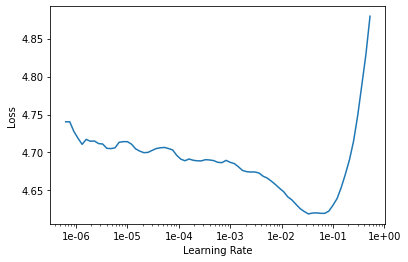

In [ ]:
learn_lm.recorder.plot(skip_end=15)

In [ ]:
lr = 1e-3
lr *= bs/48

#### Use the mixed-precision option, if you have it, otherwise omit this step

In [ ]:
learn_lm.to_fp16()

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (90000 items)
x: LMTextList
xxbos a film so insecure the xxunk perhaps hoped to milk an original film noir classic title , " xxmaj farewell xxmaj my xxmaj lovely " , thinking the gullible would assume it a remake . xxmaj the characters are so foul and unappealing that it deserved its cold reception when first released . xxmaj time only adds to it its absurdity . xxmaj having none of the guile , cinematography , desperation or despair of classic noir it relied instead on a convoluted and senseless crime plot that would have easily resulted in several arrests within hours . xxmaj as if that were n't enough it threw in an utterly sexless attempt at erotica in which at least one of the participants had n't bothered to bathe in several days . xxmaj this only made this mess all the more painful to watch . xxmaj find a good classic forties or fifties film noir instead of wasting two hours on this failure .,xxbos i had numerous problems w

#### The first step in fine-tuning is to train only the last layer of the model. 
This takes about a half-hour on an NVIDIA RTX-2070 GPU

In [ ]:
learn_lm.fit_one_cycle(1, lr*10, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.159915,4.332541,0.271429,47:43


Since this is relatively slow to train, we will save our weights:

In [ ]:
learn_lm.save('fit_1')

In [ ]:
learn_lm.load('fit_1')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (90000 items)
x: LMTextList
xxbos i saw this film again and noticed how close it is to the novel if we ignore the part about xxmaj cary 's [ xxmaj leslie xxmaj howard ] childhood . xxmaj considering that 
 
  at the time not much can be shown on the screen , [ not that there is much in the novel ] the obsession of the character with xxmaj mildred [ xxmaj bette xxmaj davis ] is very well conveyed to the audience . i recommend this film to anyone who ever fell for another person and the other side tried to take advantage of him or her . i have read that xxmaj maugham was asked to make a recording of the novel for sale , but when he started to in the studio he began crying and could not finish more than a few lines and whole project was chucked . xxmaj one can tell the novel is written from the heart and the film is a good 
 
  adaptation of a part of it at least .,xxbos xxmaj ah , noir . xxmaj my favourite genre . xxmaj otto xxmaj p

#### To complete the fine-tuning, we unfreeze all the weights and retrain
Adopting the `wikitext-103` weights as initial values, our neural network will adjust them via optimization, finding new values that are specialized to the "language" of `IMDb` movie reviews.

In [ ]:
learn_lm.unfreeze()

Fine tuning the model takes ~30 minutes per epoch on an NVIDIA RTX-2070 GPU, with bs=48<br>
Note the relatively low value of accuracy, which did not improve significantly beyond `epoch 4`.

In [ ]:
learn_lm.fit_one_cycle(10, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.851619,4.051130,0.285714,54:11
1,3.826834,4.013128,0.300000,54:08


#### Save the fine-tuned **language model** and the **encoder**
We have to save not just the `fine-tuned` **IMDb language model** but also its **encoder**. The **language model** is the part that tries to guess the next word. The **encoder** is the part that's responsible for creating and updating the hidden state. 

In the next part we will build a **sentiment classifier** for the IMDb movie reviews. To do this we will need the **encoder** from the **IMDb language model** that we built.

In [ ]:
learn_lm.save('fine_tuned')

In [ ]:
learn_lm.save_encoder('fine_tuned_enc')

#### Load the saved **model** and its **encoder**

In [ ]:
learn_lm.load('fine_tuned')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (90000 items)
x: LMTextList
  xxwrep 18 xxbos xxmaj once again xxmaj mr. xxmaj costner has dragged out a movie for far longer than necessary . xxmaj aside from the terrific sea rescue sequences , of which there are very few i just did not care about any of the characters . xxmaj most of us have ghosts in the closet , and xxmaj costner 's character are realized early on , and then forgotten until much later , by which time i did not care . xxmaj the character we should really care about is a very cocky , overconfident xxmaj ashton xxmaj kutcher . xxmaj the problem is he comes off as kid who thinks he 's better than anyone else around him and shows no signs of a cluttered closet . xxmaj his only obstacle appears to be winning over xxmaj costner . xxmaj finally when we are well past the half way point of this stinker , xxmaj costner tells us all about xxmaj kutcher 's ghosts . xxmaj we are told why xxmaj kutcher is driven to be the b

Now that we've trained our model, different representations have been learned for the words that were in `IMDb` but not `wikitext-103` (remember that at the beginning we had initialized them all to the same thing):

In [ ]:
enc = learn_lm.model[0].encoder

In [ ]:
np.allclose(enc.weight[vocab.stoi["30-something"], :], 
            enc.weight[vocab.stoi["linklater"], :])

False

In [ ]:
np.allclose(enc.weight[vocab.stoi["30-something"], :], new_word_vec)

False

#### Generate movie review-like text, with the **fine-tuned** ` IMDb` language model
Compare these texts to the ones generated with the **untrained** `IMDb model` in part **2A**. Do they seem qualitatively better?

How good is our fine-tuned IMDb language model? Well let's try to see what it predicts when given a phrase that might appear in a movie review.

In [ ]:
TEXT = "i liked this movie because"
N_WORDS = 40
N_SENTENCES = 2

In [ ]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

i liked this movie because it gave a new perspective on the subject . The story of how to kill a dog was actually a good concept that i found to be very funny . The whole movie is shot with a sense
i liked this movie because it was fun to see Fred Macmurray - a good actor - and this movie had a good cast like Gene Hackman , Gene Hackman , Catherine o'hara , William Hurt


In [ ]:
TEXT = "This movie was"
N_WORDS = 30
N_SENTENCES = 2

In [ ]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

This movie was just awful . i mean , they had a lot of money , i mean , they wanted to make money with a $ 35 million budget . And
This movie was very pleasant to watch , but it was just too dull . It took us a few minutes to catch the Mexican guy , but he seemed to


In [ ]:
TEXT = "I hated this movie"
N_WORDS = 40
N_SENTENCES = 2

In [ ]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I hated this movie , if only it ever made it to DVD . If you are planning to see this : 1 ) i would recommend that you buy this movie instead of the movie . 2 . It is
I hated this movie . It was a little too distant from the book , but the acting was good and the at least some scenes were funny . The story line was pretty good , but it was n't the best


#### Risks of language models

We will talk about ethical concerns raised by very accurate language models in lesson 7, but here are a few brief notes:

In reference to [OpenAI's GPT-2](https://www.theverge.com/2019/2/14/18224704/ai-machine-learning-language-models-read-write-openai-gpt2): Jeremy Howard said, *I’ve been trying to warn people about this for a while. We have the technology to totally fill Twitter, email, and the web up with reasonable-sounding, context-appropriate prose, which would drown out all other speech and be impossible to filter.*

For a small example, consider when completely incorrect (but reasonable sounding) ML generated answers were [posted to StackOverflow](https://meta.stackoverflow.com/questions/384596/completely-incorrect-machine-learning-generated-answers?stw=2):

<img src="https://github.com/fastai/course-nlp/blob/master/images/robot-overflow.png?raw=1" alt="Roboflow" style="width: 80%"/>

<img src="https://github.com/fastai/course-nlp/blob/master/images/husain-tweet.png?raw=1" alt="Roboflow" style="width: 60%"/>

## 3. Building an `IMDb Sentiment Classifier`
#### We'll now use **transfer learning** to create a `classifier`, again starting from the pretrained weights of the `wikitext-103` language model.  We'll also need the `IMDb language model` **encoder** that we saved previously. 

### 3A. Load and preprocess the data, and form a `databunch`
Using fastai's flexible API, we will now create a different kind of `databunch` object, one that is suitable for a **classifier** rather than a for **language model** (as we did in **2A**). This time we'll keep the labels for the `IMDb` movie reviews data. 

Add the `try-except` wrapper workaround for the bug in the `fastai Text API`

Here the batch size is decreased from 48 to 8, to avoid a `CUDA out of memory error`; your hardware may be able to handle a larger batch, in which case training will likely be faster.

Again, this takes a bit of time.

In [ ]:
bs=8

In [ ]:
%%time

# throws `BrokenProcessPool' Error sometimes. Keep trying `till it works!
#    the progress bar has to complete three consecutive steps. Why three? 
#    fails nearly 100 times, and doesn't respond to interrupt
count = 0
error = True
while error:
    try: 
        # Preprocessing steps
        data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
             #grab all the text files in path
             .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder(classes=['neg', 'pos']))
             #label them all with their folders
             #.databunch(bs=bs, num_workers=1))
        error = False
        print(f'failure count is {count}\n')   
        
    except: # catch *all* exceptions
        # accumulate failure count
        count = count + 1
        print(f'failure count is {count}')

failure count is 5

Wall time: 9min 15s


#### Form the preprocessed data into a `databunch`

In [ ]:
data_clas = data_clas.databunch(bs=bs, num_workers=1)

#### Save the databunch (since it took so long to make) and load it

In [ ]:
data_clas.save('imdb_textlist_class')

In [ ]:
data_clas = load_data(path, 'imdb_textlist_class', bs=bs, num_workers=1)

In [ ]:
data_clas.show_batch()

text,target
xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules,pos
"xxbos xxmaj some have praised _ xxunk _ as a xxmaj disney adventure for adults . i do n't think so -- at least not for thinking adults . \n \n xxmaj this script suggests a beginning as a live - action movie , that struck someone as the type of crap you can not sell to adults anymore . xxmaj the "" crack staff "" of many older",neg
"xxbos xxmaj this movie was recently released on xxup dvd in the xxup us and i finally got the chance to see this hard - to - find gem . xxmaj it even came with original theatrical previews of other xxmaj italian horror classics like "" xxup xxunk "" and "" xxup beyond xxup the xxup darkness "" . xxmaj unfortunately , the previews were the best thing about this",neg
"xxbos xxmaj there are many adaptations of xxmaj charlotte xxmaj brontë 's classic novel "" xxmaj jane xxmaj eyre "" , and taking into consideration the numerous reviews written about them there is also a lively discussion on which of them is the best . xxmaj the short film adaptations all suffer from the fact that it is simply not possible to cram the whole plot of the novel into",pos
"xxbos xxmaj title : xxmaj zombie 3 ( 1988 ) \n \n xxmaj directors : xxmaj mostly xxmaj lucio xxmaj fulci , but also xxmaj claudio xxmaj fragasso and xxmaj bruno xxmaj mattei \n \n xxmaj cast : xxmaj xxunk xxunk , xxmaj massimo xxmaj xxunk , xxmaj beatrice xxmaj ring , xxmaj deran xxmaj xxunk \n \n xxmaj review : \n \n xxmaj to review",neg


### 3B. Create a model to **classify** the `IMDb` reviews, and load the **encoder** we saved before.
#### Freeze the weights for all but the last layer and find a good value for the learning rate. 

In [ ]:
learn_c = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.3).to_fp16()
learn_c.load_encoder('fine_tuned_enc')
learn_c.freeze()

In [ ]:
learn_c.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


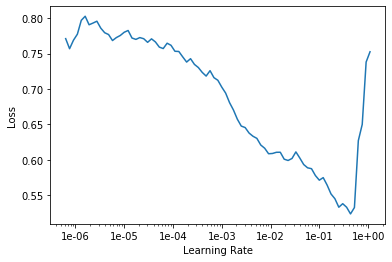

In [ ]:
learn_c.recorder.plot()

### 3C. Training and fine-tuning the `IMDb sentiment classifier`

#### Train for one cycle, save intermediate result

In [ ]:
learn_c.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.287057,0.202339,0.932720,06:29


In [ ]:
learn_c.save('first')

In [ ]:
learn_c.load('first');

#### Unfreeze last two layers and train for one cycle, save intermediate result.

In [ ]:
learn_c.freeze_to(-2)
learn_c.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.253536,0.164451,0.943320,07:25


In [ ]:
learn_c.save('2nd')

#### Unfreeze the last three layers, and train for one cycle, and save intermediate result.
At this point we've already beaten the 2017 (pre-transfer learning) state of the art!

In [ ]:
learn_c.freeze_to(-3)
learn_c.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.207790,0.151074,0.947320,09:21


In [ ]:
learn_c.save('3rd')

In [ ]:
learn_c.load('3rd')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (25000 items)
x: TextList
xxbos xxmaj story of a man who has unnatural feelings for a pig . xxmaj starts out with a opening scene that is a terrific example of absurd comedy . a formal orchestra audience is turned into an insane , violent mob by the crazy xxunk of it 's singers . xxmaj unfortunately it stays absurd the xxup whole time with no general narrative eventually making it just too off putting . xxmaj even those from the era should be turned off . xxmaj the cryptic dialogue would make xxmaj shakespeare seem easy to a third grader . xxmaj on a technical level it 's better than you might think with some good cinematography by future great xxmaj vilmos xxmaj zsigmond . xxmaj future stars xxmaj sally xxmaj kirkland and xxmaj frederic xxmaj forrest can be seen briefly .,xxbos xxmaj airport ' 77 starts as a brand new luxury 747 plane is loaded up with valuable paintings & such belonging to rich businessman xxmaj philip xxmaj steven

#### Unfreeze all the layers, train for two cycles, and save the result.

Note: at this step I encountered a `CUDA error: unspecified launch failure`. This is a known (and unsolved) problem with PyTorch when using an LSTM. https://github.com/pytorch/pytorch/issues/27837

Nothing to do but try again... and it worked on the second try.

In [ ]:
learn_c.unfreeze()
learn_c.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.205716,0.144805,0.948720,12:00
1,0.132235,0.142493,0.949320,12:01


The state of the art for this dataset in 2017 was 94.1%, and we have crushed it!!!

#### Save the IMDb classifer model

In [ ]:
learn_c.save('clas')

#### Let's look at a few examples, just to check that the classifier is working as we think it should. 
The three outputs of the model predition are the label (`pos` or `neg`) and the class probability estimates for `neg` and `pos`, which meausure the model's confidence in it's prediction. As we'd expect, the model is extremely confident that the first review is `pos` and quite confident that the second review is `neg`. So it passes the test with flying colors. 

In [ ]:
learn_c.predict("I really loved that movie, it was awesome!")

C:\Users\cross-entropy\Anaconda3\envs\fastai\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category pos, tensor(1), tensor([0.0161, 0.9839]))

In [ ]:
learn_c.predict("I didn't really love that movie, and I didn't think it was awesome.")

C:\Users\cross-entropy\Anaconda3\envs\fastai\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category neg, tensor(0), tensor([0.9698, 0.0302]))

#### Now that we've built the model, here is the part where you get to have some fun!! Take the model for a spin, try out your own examples!!

## Appendix: Language Model Zoo

fast.ai alumni have applied ULMFit to dozens of different languages, and have beat the SOTA in Thai, Polish, German, Indonesian, Hindi, & Malay.

They share tips and best practices in [this forum thread](https://forums.fast.ai/t/language-model-zoo-gorilla/14623) in case you are interested in getting involved!

<img src="https://github.com/fastai/course-nlp/blob/master/images/language_model_zoo.png?raw=1" alt="language model zoo" style="width: 80%"/>